### Load .py file
%load 01_lfs-prep.py 

### Merge lines
Merge all selected lines with Shift + M

### Write 
%%writefile 01_lfs-prep.py

## Description

1) Load capmas shapefile and create subset of Greater Cairo Region (GCR) extent

2) Create subset of Labour Force Journey (LFS) based on overlap with ADM3 codes

3) Create bounding box based on GCR shapefile to download addresses from OSM 

4) Create subset of addresses intersecting with GCR & assign addresses codes of admin3

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import os
from itertools import compress
from shapely.ops import cascaded_union
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

/Users/tjark/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_17790/49068324.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://s

In [4]:
pwd

'/Users/tjark/Documents/Python/CairoPopulation.nosync/tfc-git'

In [3]:
#move working directory up to acces data with relative paths
os.chdir("..")

### 1) Load capmas shapefile and create subset of Greater Cairo Region (GCR) extent

In [5]:
#load files
egyshp = gpd.read_file('data/raw/eg_admin_boundaries/egy_admbnda_adm3_capmas_20170421.shp')
gcrcds = pd.read_csv('data/raw/gcr_admin3_pcodes.csv')

In [6]:
#Filter if areas are in admin3 list
gcr_ind = egyshp['ADM3_PCODE'].isin(gcrcds['ADM3_PCODE'])
gcrshp = egyshp[gcr_ind]

<AxesSubplot:>

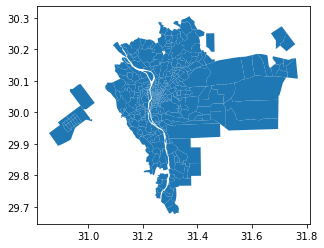

In [7]:
#Plot new shapefile 
%matplotlib inline
gcrshp.plot()

In [8]:
#Export shapefile
gcrshp.to_file("data/interim/gcrshp.shp")

### 2) Create subset of Labour Force Journey (LFS) based on area codes

In [9]:
#read labour force surveys
lfshh = pd.read_csv('data/raw/lfs/lfs-hh.csv')
lfsind = pd.read_csv('data/raw/lfs/lfs-ind.csv')

In [10]:
#transform area codes and add new column to LFS hh and indivudal dataframes
lfshh['AREA_S'] = lfshh['AREA_S'].astype(str)
lfshh['ADM3_PCODE'] = "EG" + lfshh['AREA_S'].str[3:]
lfsind['AREA_S'] = lfsind['AREA_S'].astype(str)
lfsind['ADM3_PCODE'] = "EG" + lfsind['AREA_S'].str[3:]

In [11]:
lfshh.head()

,Unnamed: 0,COUNTRY,YEAR,ROUND,DTYPE,CASESER,REG,AREA,AREA_S,RURURB,...,EMPSTABSP_3,TOTWAGHD,TOTWAGSP_1,TOTWAGSP_2,TOTWAGSP_3,IRRGWAGHD,IRRGWAGSP_1,IRRGWAGSP_2,IRRGWAGSP_3,ADM3_PCODE
0,1,818,2018,1,1,10110110150001,818001,8180132,818013202,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202
1,2,818,2018,1,1,10110110150002,818001,8180132,818013202,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202
2,3,818,2018,1,1,10110110150003,818001,8180132,818013202,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202
3,4,818,2018,1,1,10110110150004,818001,8180132,818013202,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202
4,5,818,2018,1,1,10110110150007,818001,8180132,818013202,1,...,NaN,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202


In [12]:
lfsind.head()

,Unnamed: 0,COUNTRY,YEAR,ROUND,DTYPE,CASESER,PNUM,PWEIGHT,REG,AREA,...,SRCHACT_04,SRCHACT_05,SRCHACT_06,SRCHACT_07,SRCHACT_08,SRCHACT_09,SRCHACT_10,SRCHACT_90,NOTSRCH_R,ADM3_PCODE
0,1,818,2018,1,1,10110110150001,1,287.494438,818001,8180132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EG013202
1,2,818,2018,1,1,10110110150001,2,403.016385,818001,8180132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202
2,3,818,2018,1,1,10110110150001,3,403.016385,818001,8180132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202
3,4,818,2018,1,1,10110110150001,4,270.249019,818001,8180132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,EG013202
4,5,818,2018,1,1,10110110150002,1,367.696135,818001,8180132,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,EG013202


In [13]:
#Filter lfs if areas are in gcr  
gcrlfshh = lfshh['ADM3_PCODE'].isin(gcrshp['ADM3_PCODE'])
hh = lfshh[gcrlfshh]
gcrlfsind = lfsind['ADM3_PCODE'].isin(gcrshp['ADM3_PCODE'])
ind = lfsind[gcrlfsind]

In [14]:
#Write ind and hh files to csv
hh.to_csv('data/interim/hh.csv')
ind.to_csv('data/interim/ind.csv')

### 3) Create bounding box based on GCR shapefile to download addresses from OSM 

In [15]:
sf = shp.Reader("data/interim/gcrshp.shp")

In [16]:
sf.bbox

[30.856798749000063, 29.677538105000053, 31.76807858600006, 30.30453145000007]

### 4) Create subset of addresses intersecting with GCR & assign address codes of admin3

In [17]:
osmaddresses = gpd.read_file('data/raw/osm/addresses/GCR_addresses.gpkg')

In [18]:
#Spatial intersect for points and areas
gcrpts = gpd.tools.sjoin(osmaddresses, gcrshp, predicate="within", how='inner')

In [19]:
#Delete all columns not needed
gcrpts = gcrpts.drop(columns=['name','building','index_right','ADM3_EN','ADM3_AR','ADM3_REF','ADM3ALT1EN',
                              'ADM3ALT2EN','ADM3ALT1AR','ADM3ALT2AR','ADM2_EN','ADM2_AR','ADM2_PCODE',
                              'ADM1_EN','ADM1_AR','ADM1_PCODE','ADM0_EN','ADM0_AR','ADM0_PCODE',
                              'date','validOn','validTo','Shape_Leng','Shape_Area'])

In [20]:
gcrpts.head()

,osm_id,addr:street,addr:housenumber,geometry,ADM3_PCODE
0,27565120,NaN,NaN,POINT (31.21181 29.98708),EG210402
205,343684991,NaN,NaN,POINT (31.22480 29.99188),EG210402
953,1131555201,NaN,NaN,POINT (31.21190 29.98111),EG210402
1213,1939438615,NaN,NaN,POINT (31.21512 29.99033),EG210402
1232,1942660731,NaN,NaN,POINT (31.21438 29.98802),EG210402


In [21]:
#Export to shapefile
gcrpts.to_file("data/interim/gcrpts.shp")


/var/folders/93/smcvnv_s04v84f_dnqvd4xkw0000gn/T/ipykernel_17790/628154508.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gcrpts.to_file("data/interim/gcrpts.shp")
